In [1]:
# Import necessary dependencies
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tiffile

from skimage import measure
from skimage.color import label2rgb
from skimage.filters import threshold_otsu

Synthetic reference: spheres with variable radii - compute ratio between radius and distance from the centre at which signal decays to max/2

In [2]:
# Source: https://stackoverflow.com/questions/46626267/how-to-generate-a-sphere-in-3d-numpy-array
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0

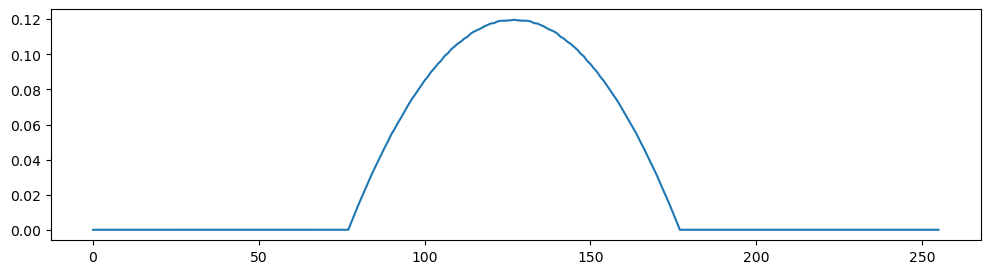

In [3]:
# We can now simulate the z-profile of a perfect sphere
# here with radius 50px, centred at position 127 out of 256 sided volume.
radius = 50
centre = 127
arr = sphere((256, 256, 256), radius, (centre, centre, centre))
# plotting
plt.figure(figsize = (12, 3))
profile = [np.mean(arr[i]) for i in range(len(arr))]
plt.plot(profile)

In [4]:
# Find indices at FWHM (full width at half maximum)
radius = 50
centre = 127
arr = sphere((256, 256, 256), radius, (centre, centre, centre))
profile = [np.mean(arr[i]) for i in range(len(arr))]

distances = []
for i in range(len(profile)): 
    if np.abs(profile[i] - np.max(profile)/2) < 0.03*np.max(profile)/2: 
        distance = np.abs(i-centre)
        distances.append(distance)
        
print(f'Distances: {distances}')
print('Ratio: ', radius/np.mean(distances))

Distances: [35, 35]
Ratio:  1.4285714285714286


In [5]:
# Let's try again with a different radius: 80 px
radius = 80
centre = 127
arr = sphere((256, 256, 256), radius, (centre, centre, centre))
profile = [np.mean(arr[i]) for i in range(len(arr))]

distances = []
for i in range(len(profile)): 
    if np.abs(profile[i] - np.max(profile)/2) < 0.02*np.max(profile)/2: 
        distance = np.abs(i-centre)
        distances.append(distance)
print(f'Distances: {distances}')
print('Ratio: ', radius/np.mean(distances))

Distances: [57, 57]
Ratio:  1.4035087719298245


In [6]:
# Let's try again with a different radius: 100 px
radius = 100
centre = 127
arr = sphere((256, 256, 256), radius, (centre, centre, centre))
profile = [np.mean(arr[i]) for i in range(len(arr))]

distances = []
for i in range(len(profile)): 
    if np.abs(profile[i] - np.max(profile)/2) < 0.01*np.max(profile)/2: 
        distance = np.abs(i-centre)
        distances.append(distance)

print(f'Distances: {distances}')
print('Ratio: ', radius/np.mean(distances))

Distances: [71, 71]
Ratio:  1.408450704225352


The ratio between the radius and the distance from centre at which the profile decays to 1/2 of max seems to be around 1.4

In [7]:
def analysis(filepath, channel, xy_calibration, plot=True): 
    """
    channel = 0 -> DFHBI
    channel = 1 -> MG
    channel = 2 -> BF (brightfield)
    """
    # Read file and extract image stack
    droplet = cv2.imreadmulti(filepath)[1]
    # Fetch channel of interest
    droplet_ch = droplet[channel::3]
    # Compute mean of raw intensity vs Z
    mean_z = np.array([np.mean(image) for image in droplet_ch])
    if plot: 
        plt.plot(np.arange(0, len(mean_z), 1), mean_z)
        plt.ylabel('Mean intensity')
        plt.xlabel('z-height')
        if channel == 0: 
            plt.title(r'$\rm \overline{B}$')
        elif channel == 1: 
            plt.title(r'$\rm \overline{A}$')
        plt.show()
    # Let's look for the indices of the FWHM
    for i in range(len(mean_z)): 
        if np.abs(mean_z[i] - np.max(mean_z)/2) < 0.015*np.max(mean_z)/2: 
            print(f'Index: {i}')
            # We can also compute the distance from the maximum
            print(f'Distance from maximum: {i - np.argmax(mean_z)}')
            distance_from_max = i - np.argmax(mean_z)
    # Segment the mid-plane (from manual inspection)
    image = droplet_ch[36]
    thresh = threshold_otsu(image)
    binary = image > thresh

    # get object labels - multiple droplets + background
    labels = measure.label(binary)
    image_label_overlay = label2rgb(labels, image=image, bg_label=0)
    
    if plot:
        plt.imshow(image_label_overlay)
        plt.show()
    
    # Most frequent label = background
    # Get second most common label = 1st (main) droplet
    freq = np.bincount(labels.reshape(-1))
    target_label_idx1 = np.argmax(freq == np.sort(freq)[-2])
    target_label1 = np.array([i if i == target_label_idx1 else 0 
                              for i in list(labels.reshape(-1))], dtype = np.uint8).reshape(image.shape[0], image.shape[1])

    # Compute properties (props) using skimage.measure.regionprops_table
    props = [measure.regionprops_table(label, properties=('centroid',
                                                 'orientation',
                                                 'axis_major_length',
                                                 'axis_minor_length')) for label in [target_label1]]
    
    # Get diameter as the average of the minor and major axis of the fitted ellipse
    diameter = (props[0]['axis_major_length'] + props[0]['axis_minor_length'])/2
    print(diameter[0], "px")
    
    # the radius is half the diameter - we can also convert to um for ease of comparison with z via the voxel calibration
    # Voxel size: 0.1263x0.1263x0.9999 micron^3 for A_bar and 0.1224x0.1224x0.9999 micron^3 for B_bar
    radius = diameter[0]*xy_calibration/2

    current_ratio = (radius/distance_from_max) 
    # Now we can compute the rescaling factor as the ratio between the ideal radius/FWHM and the one observed in the data
    rescaling = 1.4/current_ratio

    print('Rescaling needed: ', rescaling)
    return rescaling

# This script assumes to be run in the same folder as the zoomed z-stack for single non-sticky constructs in droplets (containing subfolders `A_bar` and `B_bar`)

## Droplet with A_bar RNA NS

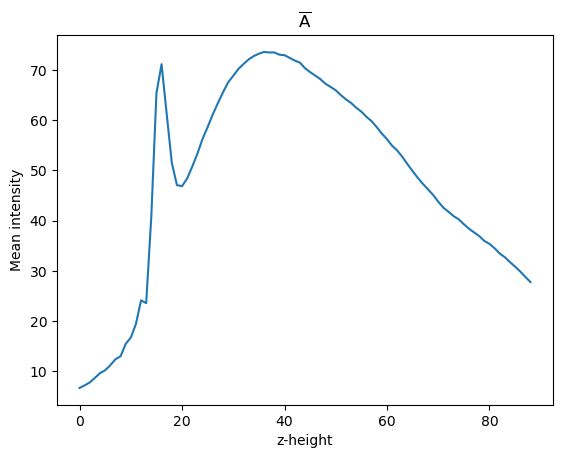

Index: 78
Distance from maximum: 42


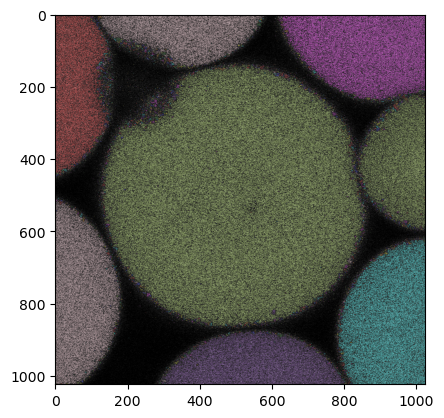

695.8405484389211 px
Rescaling needed:  1.338117463314836


In [8]:
rescaling_a_bar = analysis('A_bar/Droplets_A_bar_zoomed_zstack.tif', channel=1, xy_calibration=0.1263)

## Droplet with B_bar RNA NS

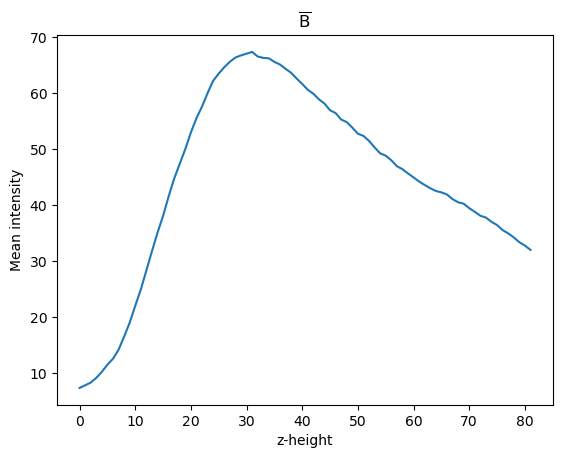

Index: 79
Distance from maximum: 48


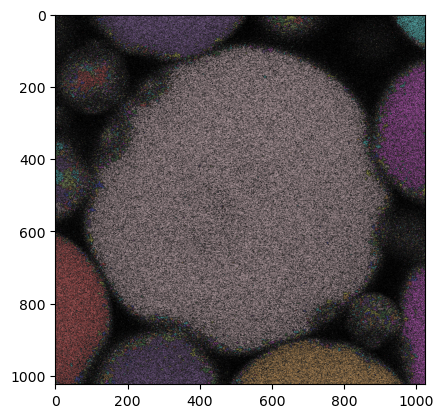

784.7917969791495 px
Rescaling needed:  1.3991471622319307


In [9]:
rescaling_b_bar = analysis('B_bar/Droplets_B_bar_zoomed_zstack.tif', channel=0, xy_calibration=0.1224)

### We can now average the rescaling factors

In [10]:
rescaling_avg = (rescaling_a_bar + rescaling_b_bar)/2
print(rescaling_avg)

1.3686323127733835
